Iterative FFT stress calculation method of

> A PHASE-FIELD MODEL FOR EVOLVING MICROSTRUCTURES WITH STRONG ELASTIC INHOMOGENEITY  
> S. Y. HU and L. Q. CHEN  
> _Acta mater._ **49** (2001) 1879–1890

applied to

> Multi phase field model for solid state transformation with elastic strain  
> I. Steinbach and M. Apel  
> _Physica D_ **217** (2006) 153-160

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [4]:
from scipy import fftpack

SA p. 157:
> The calculations were performed in a cubic domain of $15 \times 15 \times 15 \, \mathrm{\mu m}^3$

In [5]:
nx = 128

In [6]:
Lx = 15.

In [7]:
mesh = fp.Grid3D(nx=nx, ny=nx, nz=nx, Lx=Lx, Ly=Lx, Lz=Lx)

In [9]:
dX = fp.CellVariable(mesh=mesh, name=r"$\delta X$")

SA p. 157:
> the particle radius is taken as $r_p = 1.4\,\mathrm{\mu m}$

In [10]:
rp = 1.4

In [11]:
dX.setValue(1., where=(mesh.x - Lx / 2.)**2 + (mesh.y - Lx / 2.)**2 + (mesh.z - Lx / 2.)**2 <= rp**2)

## reciprocal lattice vector

In [31]:
g = fp.CellVariable(mesh=mesh, name=r"$\vec{g}$", rank=1)

**Note:** Can this be done with a view instead of reshaping twice?

In [32]:
g.value.shape = (-1, g.mesh.nx, g.mesh.nx, g.mesh.nx)

In [33]:
g.value[0] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)

In [34]:
g.value[1] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis]

In [35]:
g.value[2] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis, nmx.newaxis]

In [36]:
g.value.shape = (-1, g.mesh.numberOfCells)

## stiffness tensor

SA p. 157 "for isotropic elasticity data, equal in both phases" and "We use data in the range of those for low alloyed steel: $C_{11} = 280\,\mathrm{GPa}$, $C_{12} = 120\,\mathrm{GPa}$, corresponding to an elasticity modulus $E = 208\,\mathrm{GPa}$ and a Poisson ratio $\nu = 0.3$."

In [68]:
C11 = 280e9
C12 = 120e9
nu = 0.3
C44 = (C11 - C12)/2.

In [38]:
C = nmx.zeros((3, 3, 3, 3))

For a cubic material:  
$\begin{align*}
C_{11} = C_{22} = C_{33} &\rightarrow C_{1111} = C_{2222} = C_{3333} \\
C_{12} = C_{21} = C_{13} = C_{31} = C_{23} = C_{32} &\rightarrow 
C_{1122} = C_{2211} = C_{1133} = C_{3311} = C_{2233} = C_{3322} \\
C_{44} = C_{55} = C_{66} 
&\rightarrow C_{2323} = C_{3232} = C_{2332} = C_{3223} \\
&\quad = C_{1313} = C_{3131} = C_{1331} = C_{3113} \\
&\quad = C_{1212} = C_{2121} = C_{1221} = C_{2112}
\end{align*}$

All other $C_{ij} = 0$.

In [39]:
C[0][0][0][0] = C[1][1][1][1] = C[2][2][2][2] = C11
C[0][0][1][1] = C[1][1][0][0] = C[0][0][2][2] = C[2][2][0][0] = C[1][1][2][2] = C[2][2][1][1] = C12
C[1][2][1][2] = C[2][1][2][1] = C[1][2][2][1] = C[2][1][1][2] = C44
C[0][2][0][2] = C[2][0][2][0] = C[0][2][2][0] = C[2][0][0][2] = C44
C[0][1][0][1] = C[1][0][1][0] = C[0][1][1][0] = C[1][0][0][1] = C44

HC p 1881, below Eq. (11):  
$(G^{-1}(\vec{g}))_{ik} = g^2 \lambda^\circ_{ijkl} n_j n_l$

Recasting in our notation:   
$(G^{-1}(\vec{g}))_{ik} = C^\circ_{ijkl} g_j g_l$

In [40]:
Gik_inv = nmx.einsum('ijkl,j...,l...->ik...', C, g.value, g.value)

We can't invert the (zero) CW element, but we also don't care what it is

In [41]:
Gik_inv[..., 0] = nmx.eye(3,3)

(Slow) inversion of tensor field. Opportunity to use [Wheeler's Riemann utilities](https://github.com/usnistgov/fipy/blob/riemann/fipy/tools/smallMatrixVectorOps.py)?

In [42]:
Gik = nmx.rollaxis(nmx.array(map(nmx.linalg.inv, nmx.rollaxis(Gik_inv, axis=2))), axis=0, start=3) 

In [43]:
epsilon0 = 0.01

In [44]:
eigenstrain = epsilon0 * nmx.eye(3,3)

In [2]:
eigenstress = nmx.einsum('ijkl...,kl...->ij...', C, eigenstrain)

NameError: name 'nmx' is not defined

HC p. 1881 below Eq. (11):
> $\nu^0_k(\vec{g})$ and $\delta X(\vec{g})$ are Fourier transforms of $u^0_k(\vec{r})$ and $\delta X(\vec{r})$, respectively

(**Note:** every other symbol remains the same and simply changes its argument from $\vec{r}$ to $\vec{g}$ when it Fourier transforms, but displacment magically mutates from $u$ to $\nu$?

In [46]:
dXg = fftpack.fftn(dX.value.reshape((nx, nx, nx))).reshape(-1)

HC p. 1881, Eq. (11):  
> $\nu^0_k(\vec{g}) = -i G_{ik}(\vec{g}) g_j \sigma^\circ_{ij} \delta X(\vec{g})$

In [47]:
ug = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, eigenstress) * dXg

HC p. 1882, Eq. (18):
> $\delta \epsilon_{ij}(\vec{r}) 
= \frac{1}{(2\pi)^3}\int \frac{i}{2}\left[\nu_i(\vec{g})g_j + \nu_j(\vec{g})g_i\right]
e^{i\vec{g}\cdot\vec{r}}\,d^3\vec{g}$

In [48]:
straing = 0.5j * (nmx.einsum('i...,j...->ij...', ug, g) + nmx.einsum('j...,i...->ij...', ug, g))

In [51]:
strain = fftpack.ifftn(straing.reshape((3, 3, nx,nx,nx)), axes=(2,3,4)).reshape((3, 3, -1))

p. 1881, Eq. (4):  
> $\sigma^\mathrm{el}_{ij}(\vec{r}) 
= \left[\lambda^\circ_{ijkl} + \lambda'_{ijkl}\delta X(\vec{r})\right]
\left[\epsilon_{kl}(\vec{r}) - \epsilon^\circ_{kl}(\vec{r})\right]$

Neglecting the inhomogenous elastic constants and converting to our notation:

$\sigma^\mathrm{el}_{ij}(\vec{r}) 
= C^\circ_{ijkl}
\left[\epsilon_{kl}(\vec{r}) - \epsilon^\circ_{kl} \delta X(\vec{r})\right]$


In [52]:
stress = nmx.einsum('ijkl...,kl...->ij...', C, strain - eigenstrain[..., nmx.newaxis] * dX.value)

## Comparison to analytical values

In [54]:
halfx = mesh.x[nx//2]

In [55]:
mask = ((mesh.y == halfx) & (mesh.z == halfx)).value

In [62]:
x = mesh.x[mask].value

In [57]:
sigma11 = stress[0][0][mask].real

In [58]:
sigma33 = stress[2][2][mask].real

### Eschelby solutions

SA Eq. (32):  
$\sigma_0 = \frac{2}{3}(C_{11} + C_{12})\frac{1-2\nu}{1-\nu}\epsilon^*$

In [69]:
sigma0 = (2./3) * (C11 + 2 * C12) * (1 - 2*nu) / (1 - nu) * epsilon0

In [71]:
sigma11esch = -sigma0 * (((x - Lx/2.)**2 <= rp**2) + (rp / abs(x - Lx/2.))**3 * ((x - Lx/2.)**2 > rp**2))

In [73]:
sigma33esch = -sigma0 * (((x - Lx/2.)**2 <= rp**2) - (1./2) * (rp / abs(x - Lx/2.))**3 * ((x - Lx/2.)**2 > rp**2))

### Visualization

In [53]:
from matplotlib import pyplot as plt

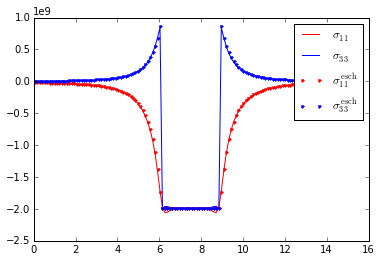

In [74]:
s11, = plt.plot(x, sigma11, 'r-', label=r"$\sigma_{11}$")
s33, = plt.plot(x, sigma33, 'b-', label=r"$\sigma_{33}$")
s11esch, = plt.plot(x, sigma11esch, 'r.', label=r"$\sigma_{11}^\mathrm{esch}$")
s33esch, = plt.plot(x, sigma33esch, 'b.', label=r"$\sigma_{33}^\mathrm{esch}$")
plt.legend(handles=[s11, s33, s11esch, s33esch])